In [80]:
import pandas as pd
import pickle
from collections import Counter
import math
import nltk
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import Lasso

%matplotlib inline

In [6]:
data = pd.read_csv("../../dados/resultado.csv", header = None) 

* Data da mensagem
* Usuário que postou a mensagem
* Texto da mensagem
* Pontuação para  classe=paródia
* Pontuação para  classe=opinião
* Pontuação para  classe=campanha
* Pontuação para  classe=experiência pessoal
* Pontuação para  classe=informação
* Resultado (qual a classe foi escolhida pela maior pontuação)
* Informação (JSON) sobre a localização

In [7]:
data.columns = ["date", "user", "message", "0", "1", "2", "3", "4", "class", "location"]

In [8]:
data.head()

,date,user,message,0,1,2,3,4,class,location
0,19/11/2010 20:04:44,PauloAfBahia,A dengue mata mas com simples gestos de preven...,0.138010,0.101521,0.254248,0.085880,0.420341,3,"{u'd': 1443198862750, u'v': 1}"
1,19/11/2010 20:05:05,PortalOuroNegro,Mutirão contra a Dengue começou nesta sexta em...,0.105452,0.056434,0.248333,0.188912,0.400869,3,"{u'city': u'Linhares', u'country': u'Brasil', ..."
2,19/11/2010 20:05:30,Kustelaas,@depChicoAlencar amannhã alem do dia da consiê...,0.054194,0.084122,0.213530,0.146927,0.501226,3,"{u'country': u'Brasil', u'state': u'MT', u'typ..."
3,19/11/2010 20:05:58,Raul_Jungmann,Pernambuco tem risco de sofrer epidemia de den...,0.080289,0.106928,0.054929,0.141276,0.616577,3,"{u'city': u'Recife', u'country': u'Brasil', u'..."
4,19/11/2010 20:06:18,laana_mello,Rpz...acho q a Caueira tah com surto de dengue...,0.112013,0.143425,0.094947,0.429626,0.219990,0,"{u'country': u'Brasil', u'state': u'MT', u'typ..."


In [9]:
data.shape

(7503165, 10)

In [10]:
#shrink database
data = data[:1000]

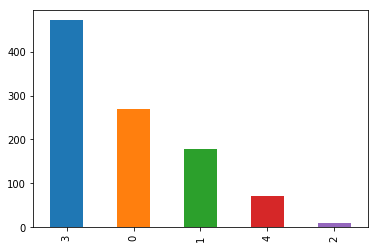

In [11]:
data['class'].value_counts().plot('bar')

In [12]:
text = pd.Series(data['message'].tolist()).astype(str)

### stopwords

In [19]:
stopwords = nltk.corpus.stopwords.words('portuguese')
stopwords = list(set(stopwords))

In [30]:
try: stopwords.remove('não')
except: pass

In [38]:
def remove_stopwords(text):
    tokens = []
    for word in text.lower().split():
        if word not in stopwords:
            tokens.append(word)
    return tokens

In [39]:
data['message_nostopwords'] = data['message'].apply(remove_stopwords)

### TF-IDF

https://www.kdnuggets.com/2018/08/wtf-tf-idf.html

In [53]:
idf_counter = Counter()
for text in data['message_nostopwords']:
    #words = text.lower().split()
    #idf_counter.update(words)
    idf_counter.update(text)

In [54]:
idf = {
  word: math.log(len(data)/df, 2)
  for word, df in idf_counter.items()
}

In [55]:
def analyze_row(row):
    target_words = row.lower().split()
    tfidf =  {
        word: (1 + math.log(_tf, 2)) * idf[word]
        for word, _tf in Counter(target_words).items()
    }
    num_words = 20
    most_frequent = [
        w  for (w, _) in Counter(target_words).most_common(num_words)
    ]
    sorted_tfidf = [
        w  for (w, _) in sorted(tfidf.items(), key=lambda kv: kv[1], reverse=True)
    ]
    print(row)
    print("Most frequent: {}".format(most_frequent))
    print("Higher TF-IDF: {}".format(sorted_tfidf[:num_words]))

In [69]:
idf_top = sorted(idf, key=idf.get)[:30]

In [72]:
for term in idf_top:
    data[term] = 0

In [76]:
def tfidf(text, term):
    tfidf = 0
    if term in text:
        tf = idf_counter[term]
        tfidf = (1 + math.log(tf, 2)) * idf[term]
        return tfidf
    return tfidf

In [78]:
for term in idf_top:
    data[term] = data['message'].apply(lambda text: tfidf(text, term))

In [67]:
sorted(idf, key=idf.get)[-4:]

['lado', 'mercadorama.', 'água,', 'qqqq']

### Lasso regression
Using Lasso to choose the most relevant terms

In [86]:
data.head()

,date,user,message,0,1,2,3,4,class,location,...,q,saúde,to,água,pra,dengue!,parada,combater,-,hoje
0,19/11/2010 20:04:44,PauloAfBahia,A dengue mata mas com simples gestos de preven...,0.138010,0.101521,0.254248,0.085880,0.420341,3,"{u'd': 1443198862750, u'v': 1}",...,0.000000,0.0,28.714269,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,19/11/2010 20:05:05,PortalOuroNegro,Mutirão contra a Dengue começou nesta sexta em...,0.105452,0.056434,0.248333,0.188912,0.400869,3,"{u'city': u'Linhares', u'country': u'Brasil', ...",...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,19/11/2010 20:05:30,Kustelaas,@depChicoAlencar amannhã alem do dia da consiê...,0.054194,0.084122,0.213530,0.146927,0.501226,3,"{u'country': u'Brasil', u'state': u'MT', u'typ...",...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,19/11/2010 20:05:58,Raul_Jungmann,Pernambuco tem risco de sofrer epidemia de den...,0.080289,0.106928,0.054929,0.141276,0.616577,3,"{u'city': u'Recife', u'country': u'Brasil', u'...",...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,19/11/2010 20:06:18,laana_mello,Rpz...acho q a Caueira tah com surto de dengue...,0.112013,0.143425,0.094947,0.429626,0.219990,0,"{u'country': u'Brasil', u'state': u'MT', u'typ...",...,28.714269,0.0,28.714269,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [90]:
data.columns[11:]

Index(['dengue', 'rt', 'é', 'combate', 'contra', 'dengue.', 'não', 'dia',
       'mosquito', 'casos', 'brasil', 'quase', 'ano', 'registra', 'relação',
       'dengue,', 'dobro', 'número', 'ta', 'd', 'q', 'saúde', 'to', 'água',
       'pra', 'dengue!', 'parada', 'combater', '-', 'hoje'],
      dtype='object')

In [91]:
X = data.iloc[:,11:]

In [93]:
X.head()

,dengue,rt,é,combate,contra,dengue.,não,dia,mosquito,casos,...,q,saúde,to,água,pra,dengue!,parada,combater,-,hoje
0,7.906893,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,28.714269,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.00000,0.000000,0.0,23.840136,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.00000,21.798437,0.0,0.000000,0.0,0.0,25.643406,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,7.906893,0.00000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,7.906893,21.34936,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,28.714269,0.0,28.714269,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X = data

#y = dados da saúde

In [ ]:
lasso = Lasso(alpha=0.4, normalize=True)

# Fit the regressor to the data
lasso.fit(X, y)

# Compute and print the coefficients
lasso_coef = lasso.coef_ 
print(lasso_coef)

# Plot the coefficients
plt.plot(range(len(X)), lasso_coef)
plt.xticks(range(len(X)), ['var 0','var 1','var 2'], rotation=60)
plt.margins(0.02)
plt.show()


# draft

In [ ]:
text_test = [['this', 'is', 'a', 'sample'], ['this', 'is', 'another', 'example']]